In [592]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [593]:
df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})

In [594]:
# Filter to only one region to test program.
region = 'Amhara'
gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json')
gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
df = df.loc[df['region'] == region]

In [595]:
df['gr_offer'].value_counts()

G.1-8       5145
G.1-4       2197
G. 9-12      185
G. 9-10      182
G. 11-12      17
Name: gr_offer, dtype: int64

In [596]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# Secondary school enrollment data. Required for calibration function?

# Data Prep

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy()
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc])
df_sec_loc = np.array([np.array(i) for i in df_sec_loc])

In [633]:
# Function estimate enrollment for schools between 2-5km with enrollment dropping off linearly.
# If the school is <2km, all primary feeder school children expected to attend secondary.
# If >5km no primary feeder school children expected. 

def shape(distance, enrollment):
    min_walk = 2
    max_walk = 5
    if distance < min_walk:
        return enrollment
    elif distance > max_walk:
        return 0
    else:
        return int(abs(enrollment*((distance - max_walk)/min_walk)))

In [598]:
x = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon,df.lat))

In [599]:
# Find the box boundary for the region
bounds = gdf_region_shp.bounds
lat_bounds = bounds[['miny','maxy']].to_numpy()
lon_bounds = bounds[['minx','maxx']].to_numpy()
print(lat_bounds, lon_bounds)

[[ 8.71481253 13.76296565]] [[35.26108445 40.21243796]]


In [600]:
# There are 4 years of upper primary, but two years of lower secondary
# It is assumed that half the population in upper primary will attend secondary.
# This is roughly 52% of the current enrollment in secondary?

# NEED TO DISCUSS. 
df_sec_enroll.sum() / (df_prim_enroll.sum() / 2)

0.51852960949575

In [601]:
np.argmin(df_prim_enroll, axis=0)

3203

In [602]:
df_prim_enroll[0]

51

In [603]:
sum(df_prim_enroll)//2

838185

In [604]:
sum(df_sec_enroll)

434624

In [638]:
## Estimate the Proportion of secondary based on primary enrollment.
enrollment_proportion = round(sum(df_sec_enroll)/ sum(df_prim_enroll//2),2) # regional average
enrollment_proportion

#### This is a problem!


# if already feeder school, then keep secondary, if new school make estimate. 

0.52

In [640]:
# Loop through each primary location and identify the minimium distance
# Calculate expected enrollment based on 

# Also want to keep track of expected enrollment per feeder school?

expected_enrollment = 0
for i in range(0, len(df_prim_loc)):
    distance = np.min(haversine_vector(df_prim_loc[i], df_sec_loc, Unit.KILOMETERS, comb=True)) # min distance in km
    s_index = np.argmin(haversine_vector(df_prim_loc[i], df_sec_loc, Unit.KILOMETERS, comb=True)) # index of min secondary
#     print(distance, s_index, i)
#     sec_enrollment = df_sec_enroll[s_index]
#     print(sec_enrollment)
#     enrollment = int(df_prim_enroll[i]*enrollment_proportion)
#     expected_enrollment += enrollment

    enrollment = int(df_prim_enroll[i] *(enrollment_proportion))
#     enrollment2 = int(df_prim_enroll[i]//2) # assume only two years will attend and apply that to shape. 
#     expected_enrollment += enrollment2
    expected_enrollment += shape(distance, enrollment) # shape based on distance.

print(expected_enrollment)

318961


In [486]:
sum(df_sec_enroll) 

434624

In [641]:
sum(df_sec_enroll) / expected_enrollment # 4.5% off. 

1.3626242706788605

In [418]:
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [790]:
if (check_region(np.array(np.array_split(sp,5)))):
    print('HELLO')

In [819]:

def expected_enrollment(prim_loc, prim_enroll, x, sec_loc):
    
    # to include: penalise if not in region. 
    
    # for each primary location, identify it's closest secondary location. 
    # if closest, then estimate expected enrollment
    # Run shape function on expected enrollment and distance
    if check_region(x):
        x = np.append(df_sec_loc, x)
        expected_enrollment = 0
        for i in range(0, len(prim_loc)): 
            distance = np.min(haversine_vector(prim_loc[i], x, Unit.KILOMETERS, comb=True)) # min distance in km # lat,lon
#             index = np.argmin(haversine_vector(df_prim_loc[i], df_sec_loc, Unit.KILOMETERS, comb=True)) # index of min secondary 
            enrollment = int(prim_enroll[i] *(1-enrollment_proportion))
            expected_enrollment += shape(distance, enrollment) # shape based on distance.
        
        return expected_enrollment
    else:
        return 0

#  or if one proposed school has enrollment of zero???
# better to add enrollment for each of the proposed schools?

In [820]:
# test_fn = expected_enrollment(df_prim_loc, df_prim_enroll, df_sec_loc, df_sec_enroll)
# test_fn

In [821]:
# The Objective Function for Random Search and CMA.
proposed_schools = 5
def f(x):
    """ The objective function which takes as input a 1d array. Every two elements represent the lat/lon of a point
    in a given area. A locations variable is created which splits the points into pairs. The total_travel_time function
    is then run on this (5,2) list to return the total travel time for the 5 estimated supermarkets.
    """
    locations = np.array(np.array_split(x, proposed_schools))
    #locations need to be only the 5 new schools. 
    # expected enrollment function then:
    # 1. adds new locations to current locations.
    # 2. checks the total new expected enrollment.
    test_case = expected_enrollment(df_prim_loc, df_prim_enroll, locations, df_sec)
    return test_case*-1

In [822]:
# Create starting points within regional box boundaries.
sp1 = np.random.uniform(low=lat_bounds[0][0], high=lat_bounds[0][1], size=5)
sp2 = np.random.uniform(low=lon_bounds[0][0], high=lon_bounds[0][1], size=5)
sp = np.vstack((sp1, sp2)).T.flatten()
# sp = np.append(df_sec_loc, sp).flatten() # add to the end of the current secondary locations

In [823]:
# boundy = [[lat_bounds[0][0],lat_bounds[0][1]],[lon_bounds[0][0], lon_bounds[0][1]]]
boundy = [min(min(lat_bounds[0]), min(lon_bounds[0])),max(max(lat_bounds[0]), max(lon_bounds[0]))]
boundy

[8.714812530000074, 40.21243796400006]

In [824]:
es.result[1]

0

In [825]:
es.result

CMAEvolutionStrategyResult(xbest=array([10.70927651, 35.64790621,  9.79002406, 38.45117104, 10.18937809,
       39.3266368 , 11.21388388, 38.98574237, 11.44502847, 37.93592823]), fbest=0, evals_best=1, evaluations=10, iterations=1, xfavorite=array([10.79699463, 35.34294415, 10.11133164, 38.45814774,  9.73793357,
       39.17565185, 10.89305897, 38.91614324, 11.42088337, 37.67809019]), stds=array([0.47520672, 0.46060806, 0.48832624, 0.46837891, 0.49059876,
       0.47626556, 0.48154675, 0.46624652, 0.48411396, 0.48291128]), stop={'tolfun': 1e-11})

In [827]:
maxits=  10000
es = cma.CMAEvolutionStrategy(sp, sigma0=0.5, inopts={'bounds': boundy,'seed':12345})
es.optimize(f, iterations=maxits / es.popsize, min_iterations=1000)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=12345, Thu Jun 16 17:22:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 0.000000000000000e+00 1.0e+00 4.78e-01  5e-01  5e-01 0:00.1
    2     20 0.000000000000000e+00 1.2e+00 4.67e-01  4e-01  5e-01 0:00.1
    3     30 0.000000000000000e+00 1.3e+00 4.51e-01  4e-01  5e-01 0:00.1
    4     40 0.000000000000000e+00 1.3e+00 4.64e-01  4e-01  5e-01 0:00.2
    9     90 0.000000000000000e+00 1.5e+00 4.20e-01  4e-01  5e-01 0:01.2
   10    100 0.000000000000000e+00 1.5e+00 4.05e-01  4e-01  4e-01 0:01.2
   19    190 -5.260000000000000e+02 1.7e+00 3.37e-01  3e-01  4e-01 0:08.5
   24    240 -5.260000000000000e+02 2.0e+00 3.55e-01  3e-01  4e-01 0:16.3
   29    290 -5.260000000000000e+02 2.3e+00 5.37e-01  4e-01  7e-01 0:24.4
   35    350 -5.260000000000000e+02 2.4e+00 3.47e-01  3e-01  4e-01 0:33.8
   38    380 -5.260000000000000e+02 2.1e+00 3.17e-01  2e-01  4e-01 0:40.5
   39    390 -5.2600000000000

  137   1370 -5.260000000000000e+02 4.2e+00 2.73e-02  1e-02  3e-02 4:57.4
  138   1380 -5.260000000000000e+02 4.2e+00 2.64e-02  1e-02  2e-02 4:59.9
  139   1390 -5.260000000000000e+02 4.2e+00 2.67e-02  1e-02  2e-02 5:02.6
  140   1400 -5.260000000000000e+02 4.3e+00 2.55e-02  1e-02  2e-02 5:05.3
  141   1410 -5.260000000000000e+02 4.3e+00 2.59e-02  1e-02  2e-02 5:07.8
  142   1420 -5.260000000000000e+02 4.3e+00 2.54e-02  1e-02  2e-02 5:10.4
  143   1430 -5.260000000000000e+02 4.2e+00 2.39e-02  1e-02  2e-02 5:13.0
  144   1440 -5.260000000000000e+02 4.0e+00 2.33e-02  1e-02  2e-02 5:15.6
  145   1450 -5.260000000000000e+02 4.1e+00 2.12e-02  9e-03  2e-02 5:18.4
  146   1460 -5.260000000000000e+02 4.0e+00 2.08e-02  9e-03  2e-02 5:21.0
  147   1470 -5.260000000000000e+02 4.0e+00 2.03e-02  9e-03  2e-02 5:23.6
  148   1480 -5.260000000000000e+02 4.1e+00 1.97e-02  9e-03  2e-02 5:26.2
  149   1490 -5.260000000000000e+02 4.1e+00 1.91e-02  8e-03  2e-02 5:28.8
  150   1500 -5.260000000000000e+02 4.

  248   2480 -5.260000000000000e+02 1.5e+01 8.87e-03  3e-03  9e-03 9:48.8
  249   2490 -5.260000000000000e+02 1.5e+01 8.64e-03  3e-03  8e-03 9:51.4
  250   2500 -5.260000000000000e+02 1.6e+01 7.77e-03  3e-03  8e-03 9:54.1
  251   2510 -5.260000000000000e+02 1.6e+01 7.94e-03  3e-03  8e-03 9:56.6
  252   2520 -5.260000000000000e+02 1.7e+01 8.33e-03  3e-03  8e-03 9:59.2
  253   2530 -5.260000000000000e+02 1.7e+01 9.02e-03  3e-03  9e-03 10:01.8
  254   2540 -5.260000000000000e+02 1.7e+01 8.82e-03  3e-03  9e-03 10:04.5
  255   2550 -5.260000000000000e+02 1.8e+01 8.38e-03  3e-03  8e-03 10:07.1
  256   2560 -5.260000000000000e+02 1.8e+01 7.91e-03  3e-03  8e-03 10:09.7
  257   2570 -5.260000000000000e+02 1.8e+01 7.59e-03  3e-03  7e-03 10:12.3
  258   2580 -5.260000000000000e+02 1.8e+01 7.18e-03  2e-03  7e-03 10:14.9
  259   2590 -5.260000000000000e+02 1.8e+01 7.10e-03  2e-03  7e-03 10:17.5
  260   2600 -5.260000000000000e+02 1.8e+01 7.44e-03  2e-03  7e-03 10:20.1
  261   2610 -5.26000000000000

  358   3580 -5.260000000000000e+02 2.2e+01 7.42e-03  3e-03  6e-03 17:39.9
  359   3590 -5.260000000000000e+02 2.1e+01 7.44e-03  2e-03  6e-03 17:44.3
  360   3600 -5.260000000000000e+02 2.1e+01 7.73e-03  3e-03  7e-03 17:48.8
  361   3610 -5.260000000000000e+02 2.3e+01 7.68e-03  2e-03  7e-03 17:53.6
  362   3620 -5.260000000000000e+02 2.3e+01 7.34e-03  2e-03  6e-03 17:58.2
  363   3630 -5.260000000000000e+02 2.3e+01 6.98e-03  2e-03  6e-03 18:02.7
  364   3640 -5.260000000000000e+02 2.3e+01 7.01e-03  2e-03  6e-03 18:07.4
  365   3650 -5.260000000000000e+02 2.2e+01 7.24e-03  2e-03  6e-03 18:12.2
  366   3660 -5.260000000000000e+02 2.2e+01 7.08e-03  2e-03  6e-03 18:17.0
  367   3670 -5.260000000000000e+02 2.2e+01 7.67e-03  2e-03  6e-03 18:21.2
  368   3680 -5.260000000000000e+02 2.2e+01 8.24e-03  2e-03  7e-03 18:26.0
  369   3690 -5.260000000000000e+02 2.2e+01 8.85e-03  3e-03  7e-03 18:30.6
  370   3700 -5.260000000000000e+02 2.2e+01 1.00e-02  3e-03  8e-03 18:35.4
  371   3710 -5.260000000

  468   4680 -5.260000000000000e+02 5.1e+01 1.44e-02  4e-03  1e-02 38:26.4
  469   4690 -5.260000000000000e+02 5.1e+01 1.47e-02  4e-03  1e-02 38:31.7
  470   4700 -5.260000000000000e+02 5.0e+01 1.46e-02  4e-03  1e-02 38:36.9
  471   4710 -5.260000000000000e+02 5.3e+01 1.38e-02  3e-03  1e-02 38:42.1
  472   4720 -5.260000000000000e+02 5.3e+01 1.35e-02  3e-03  1e-02 38:47.5
  473   4730 -5.260000000000000e+02 5.4e+01 1.34e-02  3e-03  1e-02 38:52.8
  474   4740 -5.260000000000000e+02 5.5e+01 1.48e-02  4e-03  1e-02 38:58.0
  475   4750 -5.260000000000000e+02 5.7e+01 1.63e-02  5e-03  2e-02 39:03.3
  476   4760 -5.260000000000000e+02 5.7e+01 1.83e-02  5e-03  2e-02 39:08.6
  477   4770 -5.260000000000000e+02 5.9e+01 1.93e-02  6e-03  2e-02 39:14.0
  478   4780 -5.260000000000000e+02 6.2e+01 1.84e-02  5e-03  2e-02 39:19.1
  479   4790 -5.260000000000000e+02 6.1e+01 1.79e-02  5e-03  2e-02 39:24.3
  480   4800 -5.260000000000000e+02 6.1e+01 1.73e-02  5e-03  2e-02 39:29.6
  481   4810 -5.260000000

  578   5780 -5.260000000000000e+02 8.9e+01 1.43e-02  4e-03  1e-02 47:20.0
  579   5790 -5.260000000000000e+02 9.1e+01 1.54e-02  4e-03  1e-02 47:22.8
  580   5800 -5.260000000000000e+02 9.0e+01 1.59e-02  4e-03  1e-02 47:25.6
  581   5810 -5.260000000000000e+02 8.9e+01 1.58e-02  4e-03  1e-02 47:28.2
  582   5820 -5.260000000000000e+02 8.8e+01 1.56e-02  4e-03  1e-02 47:30.8
  583   5830 -5.260000000000000e+02 8.4e+01 1.47e-02  3e-03  1e-02 47:33.4
  584   5840 -5.260000000000000e+02 8.3e+01 1.39e-02  3e-03  1e-02 47:36.1
  585   5850 -5.260000000000000e+02 8.7e+01 1.23e-02  3e-03  1e-02 47:38.7
  586   5860 -5.260000000000000e+02 9.0e+01 1.15e-02  3e-03  9e-03 47:41.4
  587   5870 -5.260000000000000e+02 9.0e+01 1.14e-02  3e-03  9e-03 47:44.0
  588   5880 -5.260000000000000e+02 8.8e+01 1.20e-02  3e-03  9e-03 47:46.6
  589   5890 -5.260000000000000e+02 8.5e+01 1.31e-02  3e-03  1e-02 47:49.2
  590   5900 -5.260000000000000e+02 8.4e+01 1.40e-02  3e-03  1e-02 47:51.8
  591   5910 -5.260000000

  688   6880 -5.260000000000000e+02 1.1e+02 1.12e-01  2e-02  7e-02 56:02.5
  689   6890 -5.260000000000000e+02 1.1e+02 1.05e-01  2e-02  7e-02 56:04.6
  690   6900 -5.260000000000000e+02 1.1e+02 9.76e-02  2e-02  6e-02 56:06.6
  691   6910 -5.260000000000000e+02 1.2e+02 8.84e-02  2e-02  6e-02 56:08.7
  692   6920 -5.260000000000000e+02 1.1e+02 9.35e-02  2e-02  6e-02 56:10.8
  693   6930 -5.260000000000000e+02 1.2e+02 9.56e-02  2e-02  6e-02 56:13.0
  694   6940 -5.260000000000000e+02 1.2e+02 9.72e-02  2e-02  6e-02 56:15.2
  695   6950 -5.260000000000000e+02 1.2e+02 9.90e-02  2e-02  6e-02 56:17.3
  696   6960 -5.260000000000000e+02 1.2e+02 1.04e-01  2e-02  7e-02 56:19.5
  697   6970 -5.260000000000000e+02 1.2e+02 9.64e-02  2e-02  6e-02 56:21.5
  698   6980 -5.260000000000000e+02 1.2e+02 9.83e-02  2e-02  6e-02 56:23.5
  699   6990 -5.260000000000000e+02 1.2e+02 9.92e-02  2e-02  6e-02 56:25.5
  700   7000 -5.260000000000000e+02 1.2e+02 9.75e-02  2e-02  6e-02 56:27.6
  701   7010 -5.260000000

KeyboardInterrupt: 

In [834]:
es.result[1]

-526

In [829]:
vec = np.array(np.array_split(es.result[0],5))
vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
vec.within(gdf_region_shp[0])

array([ True,  True,  True,  True,  True])

In [830]:
best_solution = np.array(np.array_split(es.result[0], proposed_schools))

In [831]:
# best_solution_found = np.stack(np.array_split(es.result[0], (len(df_sec_loc) + proposed_schools),axis=0))
# best_solution = np.array_split(np.array(es.result[0]), (len(df_sec_loc) + proposed_schools))
# best_solution = np.array([np.array(i) for i in best_solution])

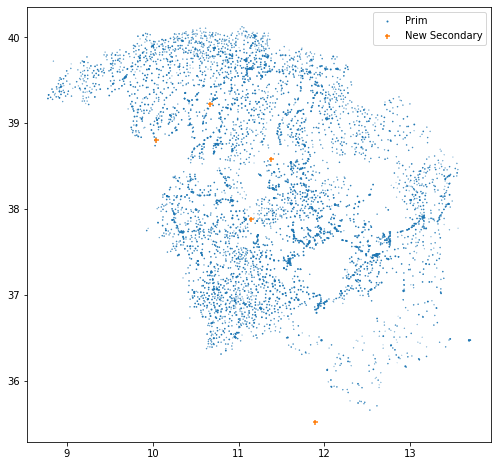

In [832]:
plt.figure(figsize=(10, 8))
plt.scatter(df_prim_loc[:, 0], df_prim_loc[:, 1], s=df_prim_enroll/1000, label="Prim") # s gives size
# plt.scatter(df_sec_loc[:, 0], df_sec_loc[:, 1], s = 10, marker="*", label="Secondary") # stars for supermarkets
plt.scatter(best_solution[:, 0], best_solution[:, 1], s = 25, marker="+", label="New Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()


In [837]:
w = np.array([0,1])
ww = np.array([[0,1],[0,1]])
ww.shape

(2, 2)

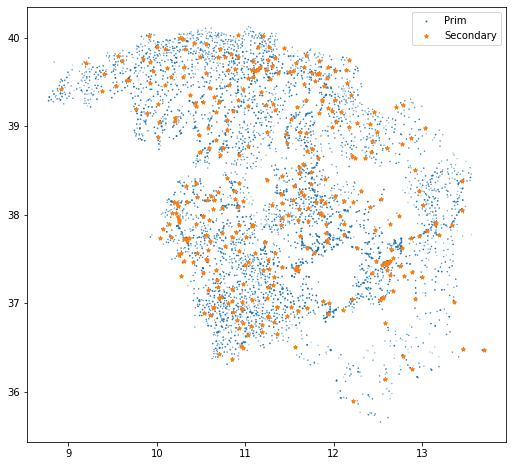

In [833]:
plt.figure(figsize=(10, 8))
plt.scatter(df_prim_loc[:, 0], df_prim_loc[:, 1], s=df_prim_enroll/1000, label="Prim") # s gives size
plt.scatter(df_sec_loc[:, 0], df_sec_loc[:, 1], s = 15, marker="*", label="Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()
